In [1]:
# Parameters
name = "S_III-9069"
bins = 4
flux_thresh = 0.01
sigma_thresh = 2.0


In [2]:
# Parameters
# name = "H_I-6563"

In [3]:
import time
start_time=time.time()
from pathlib import Path
import sys
import json
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [4]:
sys.path.append(r"C:\Users\ZAINTEL2\Dropbox\GitHub\orion_muse\py_modules")
sys.path.append(r"C:\Users\ZAINTEL2\Dropbox\GitHub\orion_muse")

from pipeline_config import OBSERVATIONS_DIR, MAPS_DIR
from rebin_utils import downsample

In [5]:

# Add path to py_modules 
#sys.path.append(str(Path().resolve().parents[0] / 'py_modules')) # 1 level up = project root

# Add path to pipeline_config.py
#sys.path.append(str(Path().resolve().parents[0]))  # 1 level up = project root

# Import from pipeline_config and py_modules
#from pipeline_config import OBSERVATIONS_DIR, MAPS_DIR
#from rebin_utils import downsample

#print("\n".join(sys.path))

In [6]:
# Input FITS files
name_export = name + '_mask'
flux_path    = OBSERVATIONS_DIR / f'linesum-{name}.fits'
radvel_path  = OBSERVATIONS_DIR / f'mean-{name}-patfixx.fits'

# Open files
flux    = fits.open(flux_path)
rad_vel = fits.open(radvel_path)

In [7]:
# Region propertires
dist   = 410   # distance [parsecs]
pix    = 0.2 # spatialscale [arcsec per pixel]

# Observation propertires
seeing = 0.9   # FWHM seeing [arcsec] 

# Conversions
pc = dist * ( 2 * np.pi ) / (360 * 60 * 60) # value in parsecs of each arcsec
s0 = (seeing  * pc) / 2.355 # RMS seeing [parsecs]
pc , s0

(0.0019877360925490972, 0.0007596443665792729)

In [8]:
sb = flux[0].data.astype(float)
vv = rad_vel[0].data.astype(float)

In [9]:
## Replace spurious values in the arrays
m = ~np.isfinite(sb*vv) | (sb < 0.0)

sb[m] = 0.0
vv[m] = np.nanmean(vv)
sb /= sb.max()

good = (~m) & (sb > 0.001)

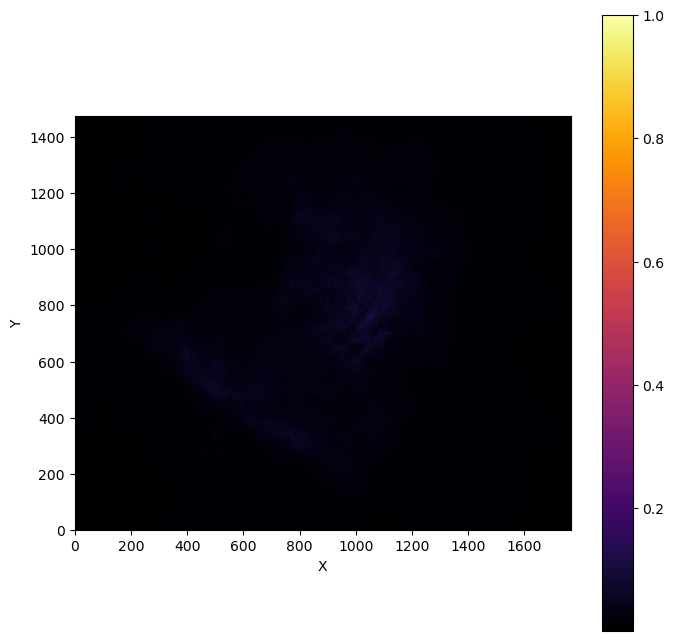

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(sb, cmap='inferno')

cbar = plt.colorbar()
plt.clim(0.001,1)
cbar.set_label(' ', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

In [11]:
sb_df       = pd.DataFrame(sb)
sb_df       = sb_df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'I'})

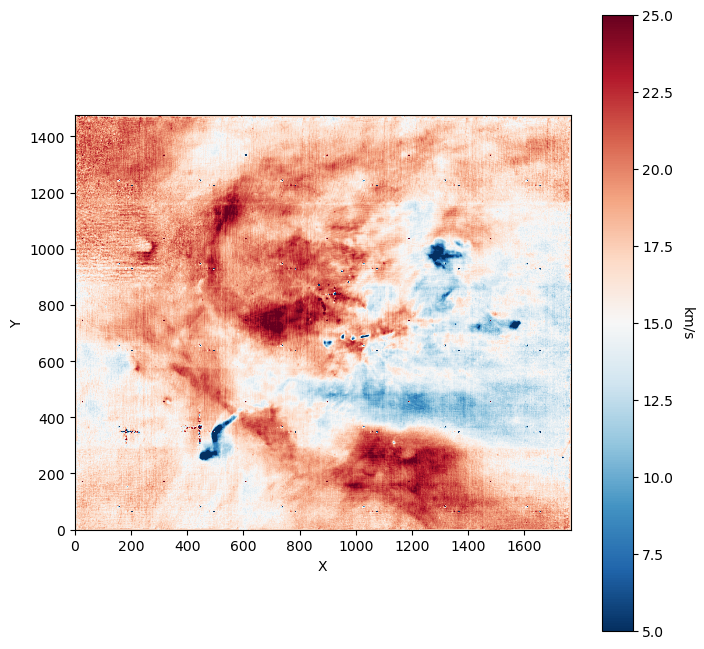

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(vv, cmap='RdBu_r')

cbar = plt.colorbar()
plt.clim(5,25)
cbar.set_label('km/s', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

In [13]:
vv_df       = pd.DataFrame(vv)
data        = vv_df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'RV'})
data['I']   = sb_df.I

In [14]:
data.describe()

,X,Y,RV,I
count,2.606616e+06,2.606616e+06,2.606616e+06,2.606616e+06
mean,7.375000e+02,8.825000e+02,1.715576e+01,1.519942e-02
std,4.260845e+02,5.098003e+02,1.328799e+01,1.433883e-02
min,0.000000e+00,0.000000e+00,-1.690391e+04,0.000000e+00
25%,3.687500e+02,4.410000e+02,1.515177e+01,5.132616e-03
50%,7.375000e+02,8.825000e+02,1.717365e+01,9.211286e-03
75%,1.106250e+03,1.324000e+03,1.924952e+01,2.163290e-02
max,1.475000e+03,1.765000e+03,6.420801e+03,1.000000e+00


In [15]:
#sns.pairplot(data, 
#             vars=["I","RV"], 
#             diag_kind='hist',  
#             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
#             diag_kws=dict(bins=20),
#            )

In [16]:
mask = (data.I > flux_thresh) & \
(data.RV > data.RV.mean() - sigma_thresh*data.RV.std()) & (data.RV < data.RV.mean() + sigma_thresh*data.RV.std())

In [17]:
#sns.pairplot(data[mask], 
#             vars=["I","RV"], 
#             diag_kind='hist',  
#             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
#             diag_kws=dict(bins=20),
#            )

In [18]:
data[mask].describe()

,X,Y,RV,I
count,1.224157e+06,1.224157e+06,1.224157e+06,1.224157e+06
mean,8.236307e+02,8.928170e+02,1.752585e+01,2.620424e-02
std,3.584466e+02,3.029850e+02,3.291801e+00,1.420124e-02
min,9.600000e+01,7.300000e+01,-9.419735e+00,1.000000e-02
25%,5.410000e+02,6.650000e+02,1.564561e+01,1.513065e-02
50%,7.930000e+02,9.050000e+02,1.776748e+01,2.268157e-02
75%,1.135000e+03,1.135000e+03,1.963058e+01,3.339985e-02
max,1.474000e+03,1.572000e+03,4.361487e+01,2.437769e-01


In [19]:
sb_mask = (data[mask].round(2)).pivot(index='Y', columns='X', values='I')
vv_mask = (data[mask].round(2)).pivot(index='Y', columns='X', values='RV')

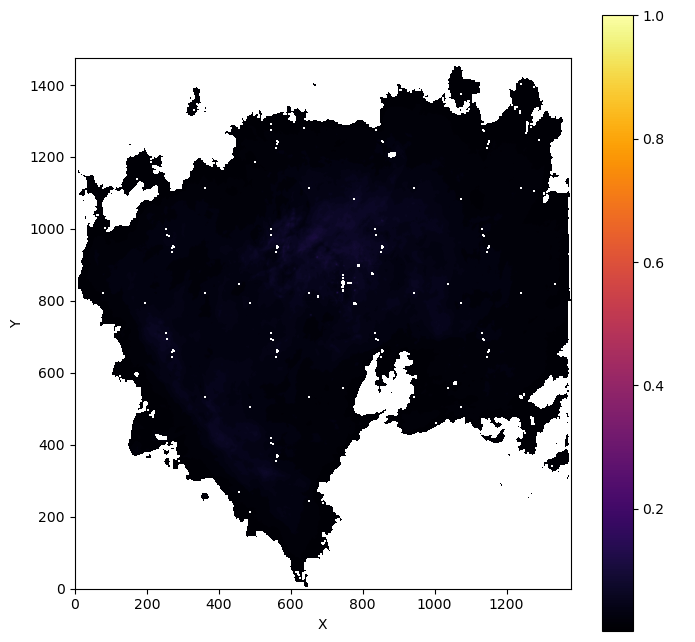

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(sb_mask, cmap='inferno')

cbar = plt.colorbar()
plt.clim(0.001,1)
cbar.set_label(' ', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

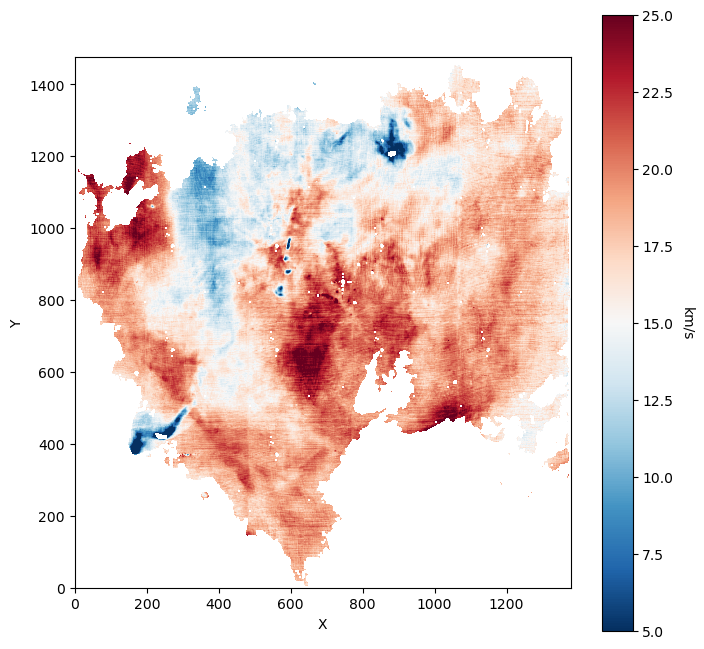

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))


plt.figure(1)
plt.imshow(vv_mask, cmap='RdBu_r')

cbar = plt.colorbar()
plt.clim(5,25)
cbar.set_label('km/s', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

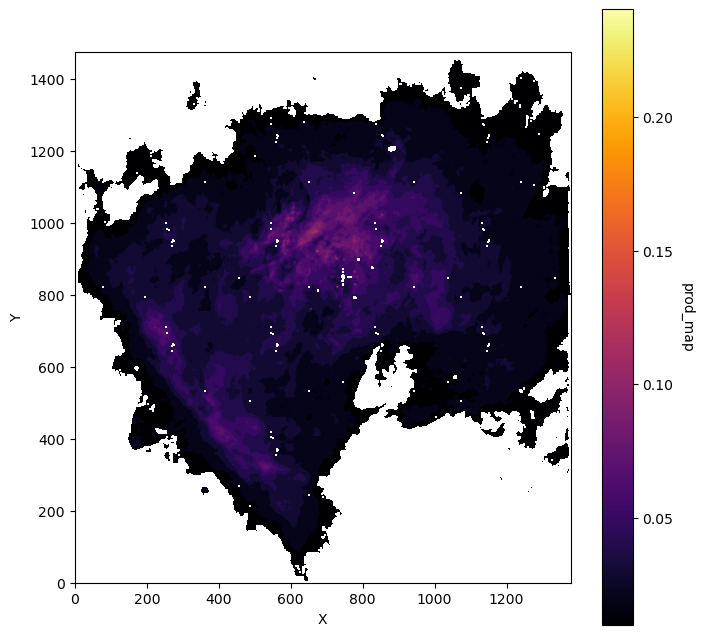

In [22]:
sb = np.array(sb_mask)
vv = np.array(vv_mask)

prod_map  = sb * vv

fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(sb, cmap='inferno')

cbar = plt.colorbar()
#plt.clim(0.001,1)
cbar.set_label('prod_map', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

In [23]:
bins = 2
mingoods  = [2]*bins
sb_       = pd.notna(sb)
vv_       = pd.notna(vv)
prod_map_ = sb_ * vv_


for mingood in zip(mingoods):
 [sb], sb_= downsample([sb], sb_, weights=None, mingood=mingood)

for mingood in zip(mingoods):
 [prod_map], prod_map_= downsample([prod_map], prod_map_, weights=None, mingood=mingood)



C:\Users\ZAINTEL2\Dropbox\GitHub\orion_muse\py_modules\rebin_utils.py:107: RuntimeWarning: invalid value encountered in divide
  (


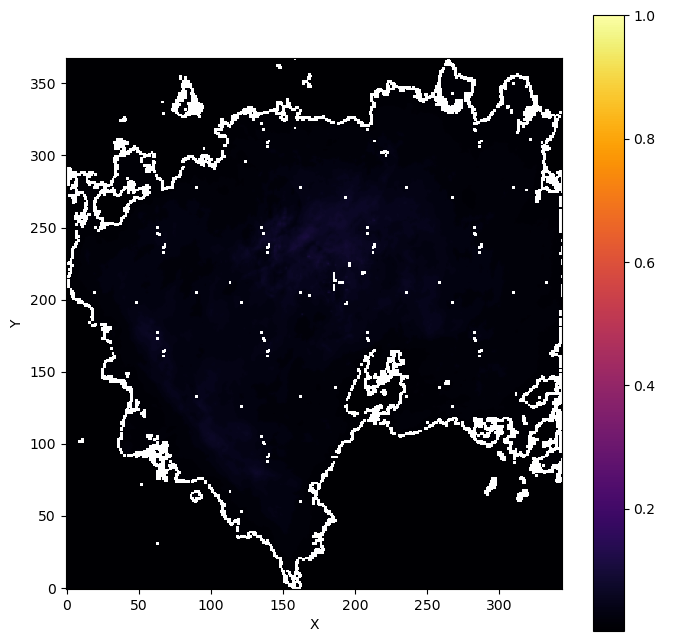

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(sb, cmap='inferno')

cbar = plt.colorbar()
plt.clim(0.001,1)
cbar.set_label(' ', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

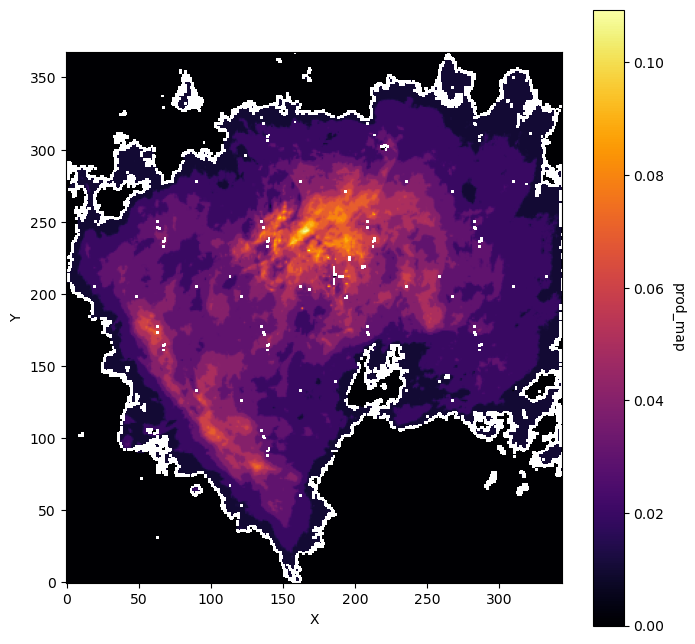

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(sb, cmap='inferno')

cbar = plt.colorbar()
#plt.clim(0.001,1)
cbar.set_label('prod_map', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

C:\Users\ZAINTEL2\AppData\Local\Temp\ipykernel_28220\4039543542.py:1: RuntimeWarning: invalid value encountered in divide
  vv = prod_map/sb


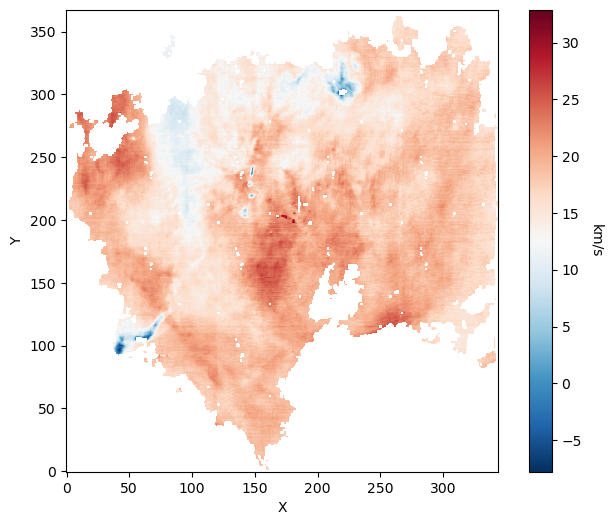

In [26]:
vv = prod_map/sb

fig, ax = plt.subplots(figsize=(8, 6))

plt.figure(1)
plt.imshow(vv, cmap='RdBu_r')

cbar = plt.colorbar()
#plt.clim(1,1.04)
cbar.set_label('km/s', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

In [27]:
len(sb)

368

In [28]:
## Replace spurious values in the arrays
m = ~np.isfinite(sb*vv) | (sb < 0.0)

sb[m] = 0.0
vv[m] = np.nanmean(vv)
sb /= sb.max()

good = (~m) & (sb > 0.001)
box_size = np.sqrt(sb.shape[0] * sb.shape[1]) * pix * pc

In [29]:
data_export_matrix = {
       'name': name_export + '_' +str(2*bins), 
       'pc' : pc,
       's0' : s0,
       'pix' : pix * (2*bins),
       'box_size' : box_size * (2*bins),
       'sb' : sb,
       'vv' : vv,
      }

data_export_matrix

{'name': 'S_III-9069_mask_4',
 'pc': 0.0019877360925490972,
 's0': 0.0007596443665792729,
 'pix': 0.8,
 'box_size': 0.5657855365178016,
 'sb': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'vv': array([[17.53576339, 17.53576339, 17.53576339, ..., 17.53576339,
         17.53576339, 17.53576339],
        [17.53576339, 17.53576339, 17.53576339, ..., 17.53576339,
         17.53576339, 17.53576339],
        [17.53576339, 17.53576339, 17.53576339, ..., 17.53576339,
         17.53576339, 17.53576339],
        ...,
        [17.53576339, 17.53576339, 17.53576339, ..., 17.53576339,
         17.53576339, 17.53576339],
        [17.53576339, 17.53576339, 17.53576339, ..., 17.53576339,
         17.53576339, 17.53576339],
        [17.53576339, 17.53576339, 17.53576339, ..., 17.53576339,
         17.53

In [30]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


In [31]:
            
jsonfilename = name_export + "_bin_" + str(2*bins) +".json"
with open(MAPS_DIR/jsonfilename, "w") as f:
    json.dump(data_export_matrix, fp=f, indent=3, cls=MyEncoder)

In [32]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 10.714918613433838 seconds ---
